In [6]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state


In [3]:
# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

Sparsity with L1 penalty: 70.19%
Test score with L1 penalty: 0.8248
Example run in 8.745 s


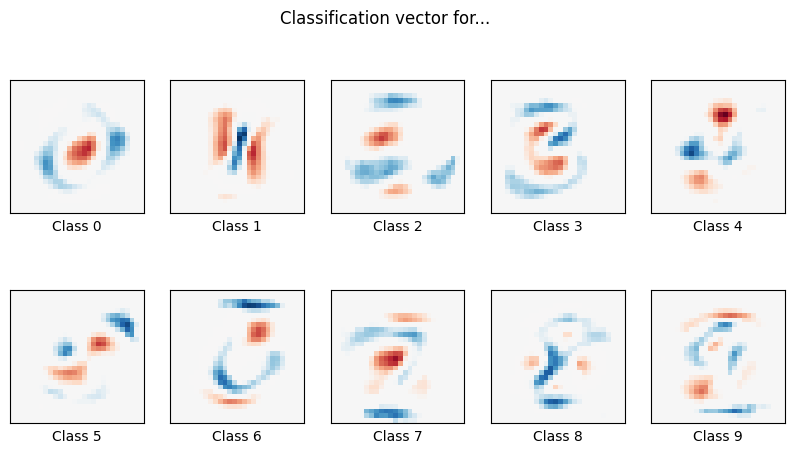

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

Iteration 1, loss = 0.96714736
Iteration 2, loss = 0.27549406
Iteration 3, loss = 0.16736249
Iteration 4, loss = 0.11674561
Iteration 5, loss = 0.07787277
Iteration 6, loss = 0.05417178
Iteration 7, loss = 0.03832546
Iteration 8, loss = 0.02807953
Iteration 9, loss = 0.02013501
Iteration 10, loss = 0.01677150
Iteration 11, loss = 0.01229955
Iteration 12, loss = 0.00991238
Iteration 13, loss = 0.00785055
Iteration 14, loss = 0.00624049
Iteration 15, loss = 0.00527658
Iteration 16, loss = 0.00461766
Iteration 17, loss = 0.00398333
Iteration 18, loss = 0.00342840
Iteration 19, loss = 0.00312995
Iteration 20, loss = 0.00279961
Test accuracy with MLP: 0.9295


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


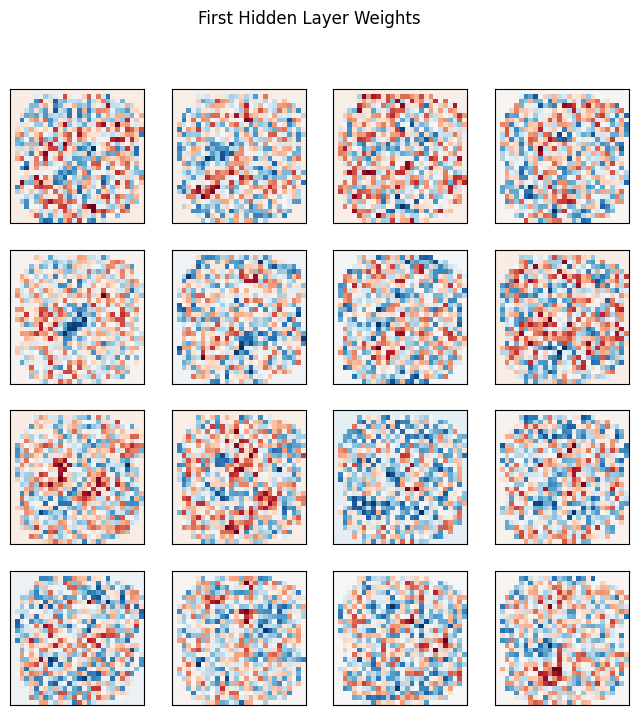

Example run in 309.110 s


In [9]:
# Define the FFNN model
clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam',
                    alpha=0.0001, batch_size=128, max_iter=20, verbose=True, random_state=1)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print("Test accuracy with MLP: %.4f" % score)

# Plot first layer weights
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    if i < clf.coefs_[0].shape[1]:
        ax.imshow(clf.coefs_[0][:, i].reshape(28, 28), cmap='RdBu_r')
        ax.set_xticks(())
        ax.set_yticks(())
plt.suptitle("First Hidden Layer Weights")
plt.show()

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
